In [1]:
import numpy as np
import torch
import copy
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
torch.cuda.device_count()

1

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [6]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.3

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(150),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# choose the training and test datasets

train_dir = 'seg_train'
test_dir = 'seg_test'


train_set = datasets.ImageFolder(train_dir, transform=transform)
test_set = datasets.ImageFolder(test_dir, transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)




# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = train_set.classes

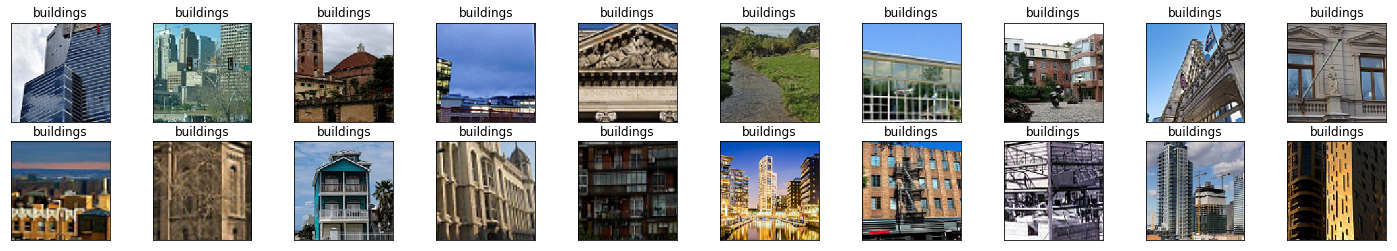

In [7]:
# visualize the train_set
# obtain one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture from this kaggle example https://www.kaggle.com/uzairrj/beg-tut-intel-image-classification-93-76-accur
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 150x150x3 image tensor)112,56,28
        self.conv1 = nn.Conv2d(3, 200, 3)
        self.conv1 = nn.DataParallel(self.conv1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(200, 180, 3)
        self.conv2 = nn.DataParallel(self.conv2)

        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(180, 180, 3)
        self.conv3 = nn.DataParallel(self.conv3)
        self.conv4 = nn.Conv2d(180, 140, 3)
        self.conv4 = nn.DataParallel(self.conv4)
        self.conv5 = nn.Conv2d(140, 100, 3)
        self.conv5 = nn.DataParallel(self.conv5)
        self.conv6 = nn.Conv2d(100, 50, 3)
        self.conv6 = nn.DataParallel(self.conv6)

        # max pooling layer
        self.pool = nn.MaxPool2d(5, 5)
        # linear layer (7 * 7 * 128 -> 1024)
        self.fc1 = nn.Linear(800, 180)
        self.fc1 = nn.DataParallel(self.fc1)
        
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(180, 100)
        self.fc2 = nn.DataParallel(self.fc2)
        self.fc3 = nn.Linear(100, 50)
        self.fc3 = nn.DataParallel(self.fc3)
        self.fc4 = nn.Linear(50, 6)
        
       
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        
        

        # flatten image input
        x = x.view(-1, 800)
        # add dropout layer
       
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
         # add dropout layer
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
model.to('cuda')

import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizernnnn
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Net(
  (conv1): DataParallel(
    (module): Conv2d(3, 200, kernel_size=(3, 3), stride=(1, 1))
  )
  (conv2): DataParallel(
    (module): Conv2d(200, 180, kernel_size=(3, 3), stride=(1, 1))
  )
  (conv3): DataParallel(
    (module): Conv2d(180, 180, kernel_size=(3, 3), stride=(1, 1))
  )
  (conv4): DataParallel(
    (module): Conv2d(180, 140, kernel_size=(3, 3), stride=(1, 1))
  )
  (conv5): DataParallel(
    (module): Conv2d(140, 100, kernel_size=(3, 3), stride=(1, 1))
  )
  (conv6): DataParallel(
    (module): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): DataParallel(
    (module): Linear(in_features=800, out_features=180, bias=True)
  )
  (fc2): DataParallel(
    (module): Linear(in_features=180, out_features=100, bias=True)
  )
  (fc3): DataParallel(
    (module): Linear(in_features=100, out_features=50, bias=True)
  )
  (fc4): Linear(in_features=50, out_features=6, bias=True)
  (

In [ ]:
train_on_gpu = True
model.cuda()
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
    
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # update the total count for labels
        total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    valid_acc = correct / total
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch, train_loss, valid_loss, valid_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'traditional_CNN_deeper.pt')
        valid_loss_min = valid_loss

In [10]:
train_on_gpu = True
model.cuda()
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
save = []
model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model

    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.534361

Test Accuracy of buildings: 81% (357/437)
Test Accuracy of forest: 95% (454/474)
Test Accuracy of glacier: 80% (444/553)
Test Accuracy of mountain: 79% (419/525)
Test Accuracy of   sea: 77% (395/510)
Test Accuracy of street: 71% (358/501)

Test Accuracy (Overall): 80% (2427/3000)
